In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

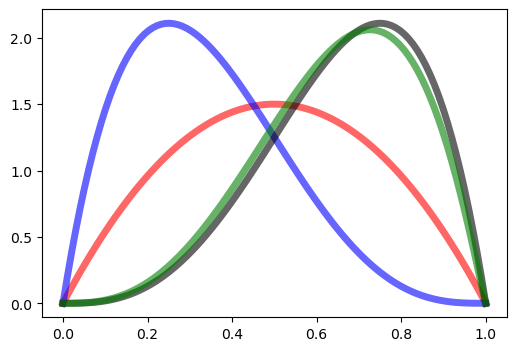

In [58]:
from scipy.stats import beta

a = [2, 4]
b = [4, 2]

r = np.random.rand()

dist = beta(np.interp(r, [0, 1], a), np.interp(r, [0, 1], b))

# x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.plot(x, beta.pdf(x, 2, 2),'r-', lw=5, alpha=0.6, label='beta pdf')
ax.plot(x, beta.pdf(x, 2, 4),'b-', lw=5, alpha=0.6, label='beta pdf')
ax.plot(x, beta.pdf(x, 4, 2),'k-', lw=5, alpha=0.6, label='beta pdf')
ax.plot(x, dist.pdf(x),'g-', lw=5, alpha=0.6, label='beta pdf')

In [20]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/graph_full_red.json')
graph = nx.DiGraph(graph)

In [21]:
places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

graph_places = src.graph.subgraph(graph, places)
# graph_stations = src.graph.subgraph(graph, stations)

In [22]:
graph.is_directed(), graph.number_of_edges()

(True, 4321520)

In [72]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
# seed = None
rng = np.random.default_rng(seed)

risk_attitude = (0, .2)
risk_attitude = (.8, 1)
rho = np.linspace(*risk_attitude, 100)

cases = 30

station_kw = {}

station_kw['place'] = {
    'cases': 1,
    'type': 'ac',
    'access': 'private',
    'price': .4 / 3.6e6,
    'setup_time': 0,
    'rng': rng,
    'power': np.inf,
}

station_kw['station'] = {
    'reliability': .5,
    'cases': cases,
    'type': 'dc',
    'access': 'public',
    'power': src.routing._network_power,
    'price': .5 / 3.6e6,
    'setup_time': 300,
    'rng': rng,
}

vehicle_kw = {
    'cases': 1,
    'linear_fraction': .8,
    'risk_attitude': (0, 1),
    # 'max_charge_start_soc': .8,
}

t0 = time.time()

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 16.3454 seconds


In [70]:
def reserve_range(graph, node):

    distances = [v['distance'] for v in graph._adj[node].values()]

    return np.sort(distances)[1:6].mean()

    

station = np.random.choice(stations)

d = reserve_range(graph, station)
d

572.0

In [38]:
# graph._adj['station_10']

In [75]:
deep_reload(src)

# vehicle_kw['max_charge_start_soc'] = .5
# vehicle = src.routing.Vehicle(**vehicle_kw)

# destinations = [k for k, v in graph._node.items() if v['type'] == 'place']
# origins = [destinations[0]]

node_to_idx = {k: idx for idx, k in enumerate(graph.nodes)}
idx_to_node = {idx: k for idx, k in enumerate(graph.nodes)}

places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

t0 = time.time()

costs, values, paths = src.floyd_warshall.floyd_warshall(
    graph,
    fields = ['routing_time', 'total_time', 'driving_time', 'distance', 'charge_event'],
    origins = places,
    destinations = places,
    pivots = stations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 17.0450 seconds


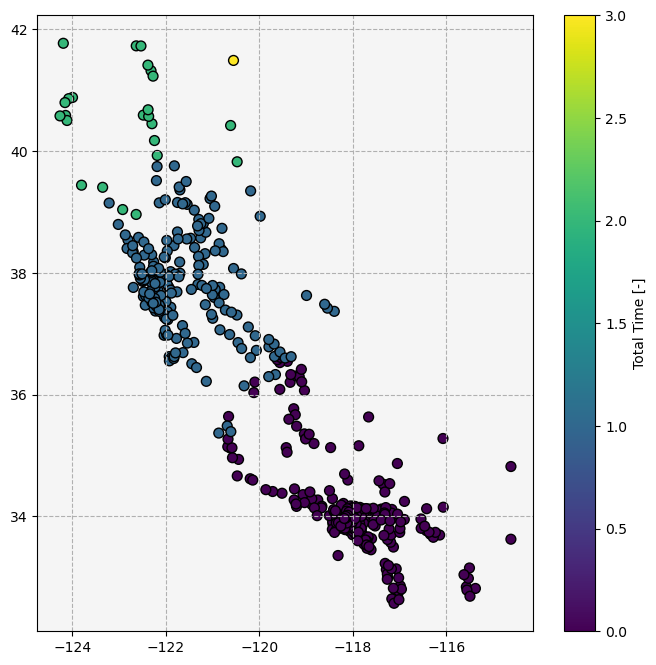

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

origin = 'San Diego'

for source, node in graph_places._node.items():

    arc = values[origin].get(source, {})

    # node['plot'] = (
    #     arc.get('routing_time', np.nan) - arc.get('time', np.nan)
    # )/ 3600

    node['plot'] = arc.get('charge_event', np.nan)

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   graph_places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

In [83]:
int(False)

0

In [29]:
values['Davis']['San Fernando']

{'routing_time': 20289.45516983016,
 'total_time': 20289.45516983016,
 'driving_time': 20289.45516983016,
 'distance': 605190.0,
 'charge_event': 0.0}

In [35]:
paths['Davis']['San Fernando']

['Davis', 'San Fernando']

In [36]:
graph['Davis']['San Fernando']

{'time': 20289.45516983016,
 'distance': 605190.0,
 'price': 0,
 'feasible': False,
 'energy': 332854500.0,
 'charging_time': 0,
 'delay_time': 0,
 'driving_time': 20289.45516983016,
 'total_time': 20289.45516983016,
 'routing_time': 20289.45516983016,
 'charge_event': 0}

In [34]:
605190.0 / 1609, 80 * 3.6e6 / 550 / 1.609e3

(376.12802983219393, 325.4421153737499)

In [31]:
values['San Diego']['Davis']

{'routing_time': 29245.146241561088,
 'total_time': 29254.10477040258,
 'driving_time': 28355.234265734274,
 'distance': 820960.0,
 'charge_event': 1.0}

In [87]:
paths['Davis']['San Fernando']

['Davis', 'station_1520', 'San Fernando']

In [121]:
graph._node['Davis']['station'].__dict__

{'seed': None,
 'rng': Generator(PCG64) at 0x7F588A33E0A0,
 'type': 'ac',
 'access': 'private',
 'cases': 1,
 'power': inf,
 'price': 1.1111111111111112e-07,
 'reliability': 1,
 'ports': 1,
 'usable_ports': 1,
 'setup_time': 0,
 'queue_kw': {},
 'vehicle': <src.routing.Vehicle at 0x7f57ab272890>,
 'delay_time': array([0.]),
 'delay_time_expected': 0.0,
 'queue_time': 0,
 'queue_time_nominal': 0,
 'delay_time_nominal': array([0.]),
 'delay_time_nominal_expected': 0.0}

In [102]:
_adj = graph._adj
_node = graph._node

# for source, adj in _adj.items():
#     for target, edge in adj.items():

target = 'station_1520'

print(
    f"to_{_node[target].get('type', 'none')}"
    )


to_station


In [17]:
g = nx.fast_gnp_random_graph(20, 1, directed = True)

g[0][6]['ff'] = 'ee'

g.adj[0][6], g.adj[6][0]

({'ff': 'ee'}, {})

In [18]:
g = nx.fast_gnp_random_graph(20, 1, directed = False)

g = nx.to_directed(g)

g[0][6]['ff'] = 'ee'

g.adj[0][6], g.adj[6][0]

({'ff': 'ee'}, {'ff': 'ee'})

In [19]:
g = nx.fast_gnp_random_graph(20, 1, directed = False)

g = nx.DiGraph(g)

g[0][6]['ff'] = 'ee'

g.adj[0][6], g.adj[6][0]

({'ff': 'ee'}, {})

({}, {})